In [4]:
import glob
import torch
import torchvision
import numpy as np
import torch.nn as nn
from astropy.io import fits

In [80]:
DATA_DIR = "./data/Real Planet/"

X = []

img = None
for fpath in glob.glob(f"{DATA_DIR}/*.fits"):
    data = fits.getdata(fpath)
    img = torch.from_numpy(data.astype(np.float32))
    shape = img.shape[1]
    img = img[:,:shape - 1, :shape - 1]
    w_h  = img.shape[1]
    shape = img.shape[1] // 2
    split = torch.split(img, (shape, shape), dim=1)
    megasplit = []
    for elem in split:
        split2 = torch.split(elem, (shape, shape), dim=2)
        megasplit.append(split2[0])
        megasplit.append(split2[1])
    X += megasplit

y = torch.tensor([0, 0, 1, 0] * (len(X) // 4))

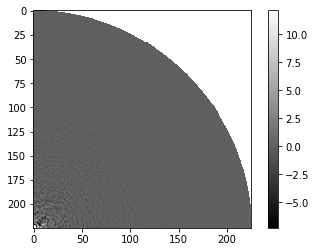

In [98]:
# Visualizing as sanity check
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(torch.split(X[2], 1, dim=0)[7].transpose(0, 2), cmap='gray')
plt.colorbar()
plt.show()

In [103]:
# Randomize orientations
import random
rots = [random.randint(0, 3) for _ in range(len(X))]
X = [torch.rot90(x, rot, [1, 2]) for rot, x in zip(rots, X)]